In [143]:
# Top level configuration options and convenience functions
ALLOW_ALL = False
ALLOWED_CATEGORIES = ["bicycling", "running", "walking"]
ALLOWED_JOINTS = [1, 4, 9, 12, 13] # r knee, l knee, head, r shoulder, l shoulder

import matplotlib.pyplot as plt
# show images
def show_image(img, gray: bool = False, annorect = None, scale = { "scale_height": 1, "scale_width": 1}):
    print(scale)
    fig, ax = plt.subplots()
    if gray:
        plt.imshow(img, 'gray')
    else: 
        plt.imshow(img)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.show()

def show_images(img1, img2, name1, name2, gray1: bool=False, gray2: bool=False, annorect = None, scale = { "scale_height": 1, "scale_width": 1}):
    fig, ax = plt.subplots(1, 2)

    fig.add_subplot(1, 2, 1)
    if gray1:
        plt.imshow(img1, 'gray')
    else:
        plt.imshow(img1)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.title(name1)

    fig.add_subplot(1, 2, 2)
    if gray2:
        plt.imshow(img2, 'gray')
    else:
        plt.imshow(img2)
    for a in annorect:
        annopoints = a["annopoints"]
        x = [x["x"] * scale["scale_width"] for x in annopoints["point"]]
        y = [y["y"] * scale["scale_height"] for y in annopoints["point"]]
        plt.plot(x, y, "ro")
    plt.title(name2)

    plt.show()


In [144]:
from json import load
from pathlib import Path

# Load the annotation data
p = (Path().resolve() / "../pose_data/annotations.json").resolve()
annotations = load(p.open())

In [145]:
from tqdm.auto import tqdm

# Parse out the categories we care about
valid_imgs = []
for i in tqdm(range(len(annotations["act"]))):
    if ALLOW_ALL or annotations["act"][i]["cat_name"] in ALLOWED_CATEGORIES:
        valid_imgs.append(i)
print(f"Indexed {len(valid_imgs)} images with valid categories")

100%|██████████| 24987/24987 [00:00<00:00, 2428526.80it/s]

Indexed 1457 images with valid categories


In [146]:
from pprint import pp

# Make sure all of the images have annopoints
annorect_imgs = []

for i in tqdm(range(len(valid_imgs))):
    i_img = valid_imgs[i]
    annolist = annotations["annolist"][i_img]
    annorects = annolist["annorect"]
    if isinstance(annorects, dict): # Only one annorect, put it in a list to make it simpler to parse everything the same
        annorects = [annorects]
    valid_annorects = []
    for a in annorects:
        if "annopoints" in a.keys():
            if isinstance(a["annopoints"], list):
                if len(a["annopoints"]) > 0:
                    valid_annorects.append(a)
            else:
                valid_annorects.append(a)
    if len(valid_annorects) > 0:
        annorect_imgs.append({"id": i_img, "annorect": valid_annorects})

print(f"Indexed {len(annorect_imgs)} images with valid annorects")

100%|██████████| 1457/1457 [00:00<00:00, 243015.11it/s]

Indexed 1385 images with valid annorects


In [147]:
import cv2
import numpy as np

images = []

# Load the images into memory

for i in tqdm(range(len(annorect_imgs))):
    image_name = annotations["annolist"][annorect_imgs[i]["id"]]["image"]["name"]
    real_path = (Path().resolve() / "../pose_data/images/" / image_name).resolve()
    img = cv2.imread(real_path.as_posix())
    if img is not None:
        images.append(
                {
                    "id": annorect_imgs[i]["id"],
                    "image": cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                    "annorect": annorect_imgs[i]["annorect"]
                }
            )

print(f"Indexed {len(images)} images for train/test")

100%|██████████| 1385/1385 [00:33<00:00, 40.86it/s]

Indexed 1385 images for train/test


{'scale_height': 1, 'scale_width': 1}


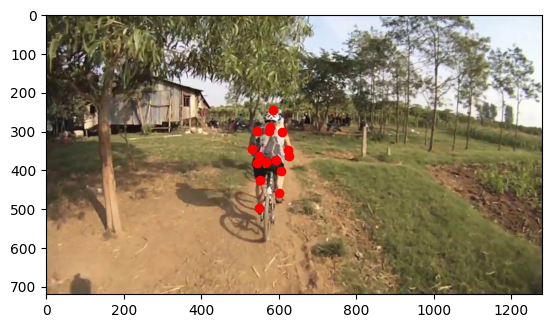

In [148]:
# Show a random image from the data
ind = np.random.randint(0, len(images))
show_image(images[ind]["image"], False, images[ind]["annorect"])

In [149]:
# Reduce the annorects to just the points we care about for our model
for i in tqdm(range(len(images))):
    annorects = images[i]["annorect"]
    for a in annorects:
        annopoints = a["annopoints"]
        if isinstance(annopoints, list):
            pp(annopoints)
            continue
        point = annopoints["point"]
        annopoints["point"] = [p for p in point if p["id"] in ALLOWED_JOINTS]

100%|██████████| 1385/1385 [00:00<00:00, 110540.25it/s]


In [150]:
# Find the smallest image
height, width, depth = images[0]["image"].shape
for i in range(len(images)):
    h_i, w_i, d_i = images[i]["image"].shape
    if h_i < height:
        height = h_i
    if w_i < width:
        width = w_i

print(f"Smallest dimensions {width} x {height}")

Smallest dimensions 600 x 432


{'scale_height': 1, 'scale_width': 1}


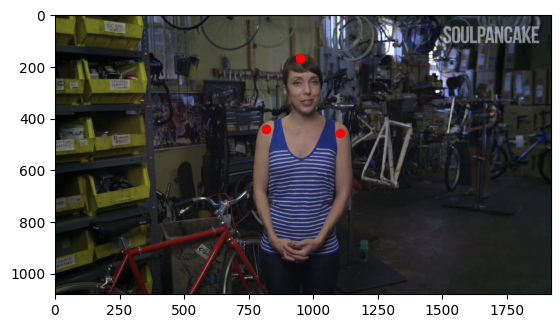

100%|██████████| 1385/1385 [03:00<00:00,  7.68it/s]


{'scale_height': 0.3333333333333333, 'scale_width': 0.3333333333333333}


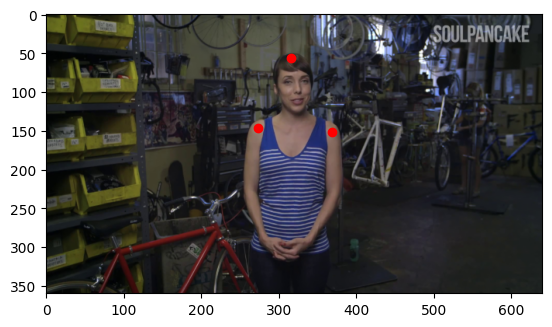

In [151]:
# Resize the images
from skimage.transform import resize

pre_scale = images[0]["image"]
show_image(pre_scale, False, images[0]["annorect"])
RESIZE_HEIGHT = 360
RESIZE_WIDTH = 640
for i in tqdm(range(len(images))):
    images[i]["scale_height"] = RESIZE_HEIGHT / images[i]["image"].shape[0] 
    images[i]["scale_width"] = RESIZE_WIDTH / images[i]["image"].shape[1]
    images[i]["image"] = resize(images[i]["image"], (RESIZE_HEIGHT, RESIZE_WIDTH))
show_image(images[0]["image"], False, images[0]["annorect"], {"scale_height": images[0]["scale_height"], "scale_width": images[0]["scale_width"]})

100%|██████████| 1385/1385 [00:02<00:00, 630.85it/s]


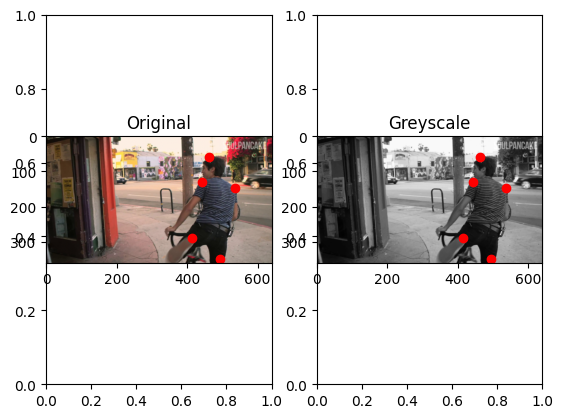

In [152]:
# Make all of the images greyscale
from skimage.color import rgb2gray

pre_grey = images[1]["image"]
for i in tqdm(range(len(images))):
    images[i]["image"] = rgb2gray(images[i]["image"])
show_images(pre_grey, images[1]["image"], "Original", "Greyscale", False, True, images[1]["annorect"], {"scale_height": images[1]["scale_height"], "scale_width": images[1]["scale_width"]})

In [156]:
# Make sure image values are [0, 1] instead of [0, 255]
print(np.max(images[0]["image"]))
print(np.min(images[0]["image"]))

print(images[0]["image"].shape)

0.9986995629072084
0.008312089601797738


In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

inputs = keras.Input(shape=(RESI, None, 1))
x = layers.Conv2D(filters=32, kernel_size=(2, 2), activation="relu")

